In [339]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Linear Regression

Using the rent prices from appartments in Lausanne from PW 02, restricting to the feature living area.

1. Load data and normalise them - as already implemented in the notebook.
2. Reproduce the closed-form solution (of the normal equations) from PW01 (based on pytorch tensors).
3. Implement (full batch) GD for linear regression - by using pytorch tensors. Don't use automatic differentiation, but implement the formulas for the gradient explicitly. Make sure that the your GD descent algorithm works correctly by checking that the solution gradually approaches the correct solution as computed in the first step (within numerical precision). Plot estimated MSE cost vs the number of epochs with matplotlib ("loss curve").
4. Play with different learning rates. Compare the trainings on the basis of the associated loss curves. Describe what you see and interpret what is going on. What is the maximal learning rate that you can use? What happens when choosing a larger learning rate?    
5. Solve the linear regression problem by using pytorch's autograd functionality.     

### 1. Load Data and Normalize

In [340]:
import pandas as pd
df = pd.read_csv("./data/lausanne-appart.csv")
N  = df.shape[0]
df.head()

,living_area,nb_rooms,rent_price
0,69,3.0,1810
1,95,3.5,2945
2,21,1.5,685
3,20,1.0,720
4,33,1.5,830


In [341]:
x0 = df.values[:,0]
x = (x0-np.mean(x0))/np.std(x0)
y0 = df.values[:,2]
y = (y0-np.mean(y0))/np.std(y0)

Text(0, 0.5, 'rent_price')

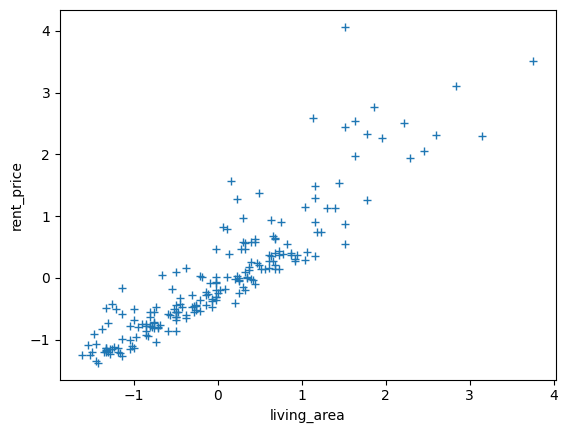

In [342]:
plt.plot(x, y,"+")
plt.xlabel("living_area")
plt.ylabel("rent_price")

### 2. Linear Model, Normal Equations and Solution

We denote the observed rent by $y_j$ (at time $x_j$) and the model rent by $\hat{y}_j$ we assume 

$\qquad \hat{y}_j = \alpha + \beta x_j$

By minimizing the mean squares error

$\qquad C = \frac{1}{2N}\sum_j \left(y_j-\hat{y}_j\right)^2 = C(\alpha,\beta)$

we can fit the straigth line as follows by using the design matrix $X$ and the data vector $Y$, defined by 

$\qquad X = \left(\begin{array}{cc} 1 & x_0 \\ 1 & x_1 \\ \vdots & \vdots \\ 1 & x_{N-1}\end{array}\right), \qquad Y = \left(\begin{array}{c} y_0\\ \vdots \\ y_{N-1}\end{array}\right)$

We find 

$\qquad \left(\begin{array}{c}\alpha \\ \beta\end{array}\right) = \left(X^T\cdot X\right)^{-1}\cdot X^T\cdot Y$

Hence, here we can easily compute the (linear) model which best fits the training data in the sense of obtaining a minimal mean square error. 

#### Solution of Normal Equations in Pytorch

tensor([[-1.9602e-16],
        [ 9.0425e-01]], dtype=torch.float64)


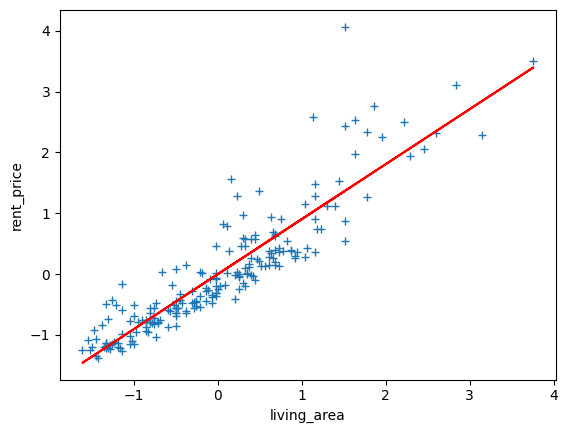

In [343]:
N = x.size

# YOUR CODE (START)
# compose torch tensors X,Y of shape (N,2) and (N,1) respectively
X = torch.empty((N, 2), dtype=torch.double)
X[:,0] = 1
X[:,1] = torch.tensor(x)
Y = torch.empty((N, 1), dtype=torch.double)
Y = torch.tensor(y).reshape(-1,1)

# solution of normal equations, 'a' a torch tensor of shape (2,1) that contains parameters alpha and beta, which shall be optimized
a_exact = (((X.T.matmul(X)).inverse()).matmul(X.T)).matmul(Y)

# prediction
Yhat = a_exact[0] + a_exact[1]*x

# YOUR CODE (END)

# plot
plt.plot(X[:,1],Y,"+")
plt.plot(X[:,1],Yhat,'r')
plt.xlabel("living_area")
plt.ylabel("rent_price")
print(a_exact)

Note that with the pytorch function `torch.lstsq` you can obtain the same.

#### Cost

In [344]:
def cost(X,Y,a):
    # YOUR CODE (START)
    N = len(X)
    Yhat = X@a
    return torch.sum((Y-Yhat)**2).item()/N # why is there a /2*N in the formula above?
    # YOUR CODE (END)

In [345]:
min_cost = cost(X,Y,a_exact)
print(min_cost)
cost_closed_form = min_cost # required later

0.18233305879162032


### 3. Gradient Descent

Specify the gradient of the cost (w.r.t. $\alpha, \beta$) here as maths expression.

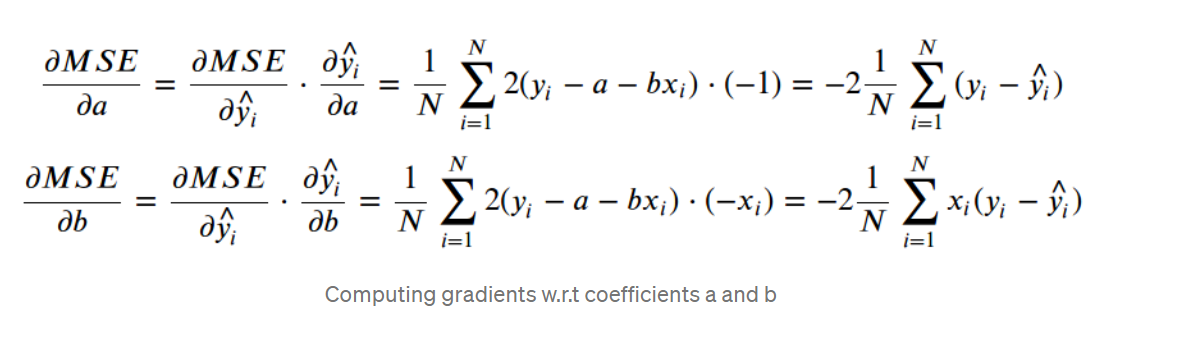

In [346]:
def gradient_cost(X,Y,a):
    # YOUR CODE (START)
    N = len(X)
    Yhat = X@a
    a_deriv = (-2/N)*torch.sum(Y-Yhat)
    b_deriv = (-2/N)*torch.sum(X*(Y-Yhat))
    return a_deriv, b_deriv
    # YOUR CODE (END)

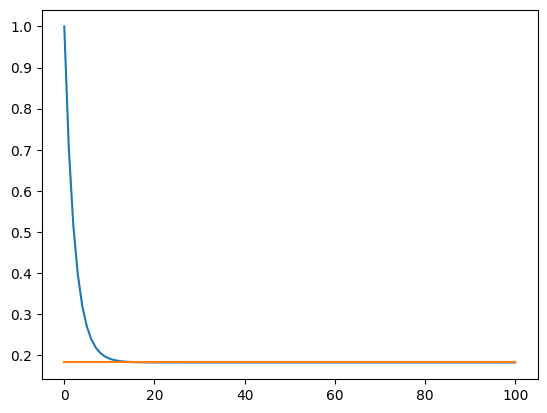

0.1823330587916203


In [347]:
# adjust if needed
nepochs = 100
lr = 0.1

## initial parameter
a = torch.tensor([0.0,0.0], dtype=torch.float64).reshape(2,1)

# track the costs
costs = [cost(X,Y,a)]

# YOUR CODE (START)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    a_deriv, b_deriv = gradient_cost(X, Y, a)
    # Update gradient
    a[0] = a[0] - lr * a_deriv
    a[1] = a[1] - lr * b_deriv   
    costs.append(cost(X,Y,a))
# YOUR CODE (END)
    
# some output
cost_gd = costs[-1]
plt.plot(range(nepochs+1),costs)
plt.plot(range(nepochs+1),cost_closed_form*torch.ones(nepochs+1))
plt.show()
print(cost_gd)

### 4. Different Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.

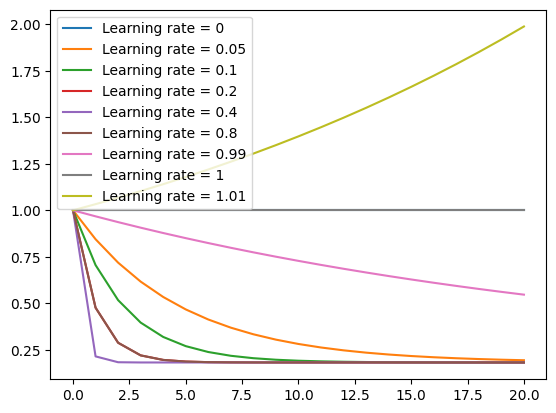

In [348]:
def do_grad_descent(X, Y, learning_rate, nepochs=20):
    ## initial parameter
    a = torch.tensor([0.0,0.0], dtype=torch.float64).reshape(2,1)
    # track the costs
    costs = [cost(X,Y,a)]
    # loop over the epochs: update parameter values, compute the cost and add it to the costs list
    for epoch in range(nepochs):
        a_deriv, b_deriv = gradient_cost(X, Y, a)
        # Update gradient
        a[0] = a[0] - lr * a_deriv
        a[1] = a[1] - lr * b_deriv   
        costs.append(cost(X,Y,a))
    return costs

learning_rates = [0, 0.05, 0.1, 0.2, 0.4, 0.8, 0.99, 1, 1.01]
costLists = []
for lr in learning_rates:
    costLists.append(do_grad_descent(X=X, Y=Y, learning_rate=lr))
    plt.plot(costLists[-1], label="Learning rate = " + str(lr))
plt.legend()

> The learning rate should be between 0 and 1. Learning rate 0 and 1 have a constant cost (no learning). For values > 1 the cost increases which makes the model worse. In theory every learning rate between 0 and 1 (without these values) should at some point converge to cost of the closed-form solution. But in this speciic scenario a learning rate of 0.4 works best (at least from the ones we tried).

### 5. Use full-fledge PyTorch

Epoch 0: loss = 1.881399104730507
Epoch 1: loss = 0.9640213923652395
Epoch 2: loss = 0.5725565753809202
Epoch 3: loss = 0.39245558332555824
Epoch 4: loss = 0.30254808510338355
Epoch 5: loss = 0.2541358554507643
Epoch 6: loss = 0.22643831338853398
Epoch 7: loss = 0.20989494903826722
Epoch 8: loss = 0.19973309837913833
Epoch 9: loss = 0.1933828388663109
Epoch 10: loss = 0.1893738697453467
Epoch 11: loss = 0.186828000416138
Epoch 12: loss = 0.18520579757239944
Epoch 13: loss = 0.18417016302211056
Epoch 14: loss = 0.18350828400701907
Epoch 15: loss = 0.18308501519231407
Epoch 16: loss = 0.18281424330268622
Epoch 17: loss = 0.18264099254796634
Epoch 18: loss = 0.18253012763661677
Epoch 19: loss = 0.18245917969915462
Epoch 20: loss = 0.18241377503726747
Epoch 21: loss = 0.1823847167801715
Epoch 22: loss = 0.18236611975717446
Epoch 23: loss = 0.18235421775661226
Epoch 24: loss = 0.18234660051014853


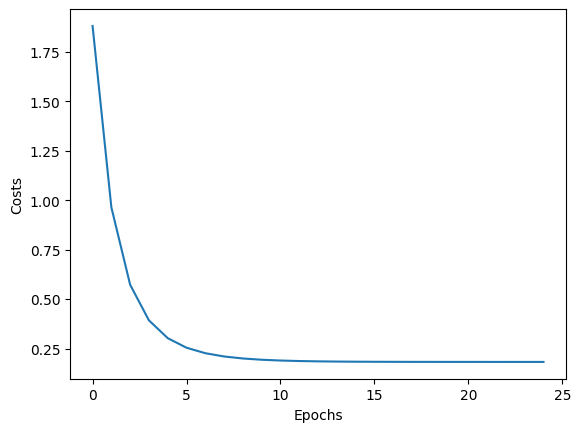

In [349]:
input_dim = X.shape[1]
output_dim = Y.shape[1]
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=input_dim, out_features=output_dim, dtype=torch.float64)
)

learning_rate = 0.1
nepochs = 25
cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
costs = []

for epochs in range(nepochs):
    pred = model(X)
    loss = cost(pred, Y)
    costs.append(loss.item()) 
    # gradient and parameter upate
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Epoch {0}: loss = {1}".format(epochs, loss))

plt.plot(costs)
plt.xlabel("Epochs")
plt.ylabel("Costs")
plt.show()
